In [ ]:
#here we test all the components.

In [1]:
'''
second performance test
'''
%time
import sys
sys.path.append('..')
%matplotlib inline
# you might need this:
#import matplotlib
#matplotlib.use('Agg')


from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.graphlearn import GraphLearnSampler
import itertools
from eden.graph import Vectorizer
import matplotlib.pyplot as plt

from eden.util import fit_estimator as eden_fit_estimator
import random
from eden.util import selection_iterator as picker
from sklearn.linear_model import SGDClassifier

vect=Vectorizer(complexity = 3)
#2401 positives and 1936 negatives
NUMPOS=2401
NUMNEG=1936

######################## testing ##############################
def get_estimator(it_pos, it_neg):
    pos= vect.transform(it_pos)
    neg = vect.transform(it_neg)
    return eden_fit_estimator(SGDClassifier(),pos,neg)


def test_estimator(estimator, pos, neg):
    count = 0
    for e in estimator.predict(pos):
        if e == 1:
            count +=1
    for e in estimator.predict(neg):
        if e!=1:
            count+=1
    return count

def train_estimator_and_evaluate_testsets(pos_real,neg_real,pos_augmented,neg_augmented,test_pos,test_neg):

    pos_real,pos_real_ = itertools.tee(pos_real,2)
    neg_real,neg_real_ = itertools.tee(neg_real,2)
    
    pos_augmented = itertools.chain(pos_augmented,pos_real_)
    neg_augmented = itertools.chain(neg_augmented,neg_real_)

    testcount= float(NUMNEG*.3+NUMPOS*.3)
    real_esti=  get_estimator(pos_real, neg_real)               #me.graphlearn_fit_estimator( pr,nr )
    aug_esti= get_estimator( pos_augmented, neg_augmented)  #  me.graphlearn_fit_estimator( pa,na )
    
    test_pos = vect.transform(test_pos)
    test_neg = vect.transform(test_neg)
    
    ori= test_estimator(real_esti,test_pos,test_neg)
    imp = test_estimator(aug_esti,test_pos,test_neg)
    
    return imp/testcount,ori/testcount


############ sampelr ###########
def unpack(graphs):
    for graphlist in graphs:
        yield graphlist[0]

def sample(graphs):

    sampler =GraphLearnSampler()
    graphs, graphs_ = itertools.tee(graphs)
    sampler.fit(graphs)
    return unpack(sampler.sample(graphs_,
                        same_radius=False,
                        same_core_size=False,
                        sampling_interval=9999,
                        select_cip_max_tries=100,
                        batch_size=30,
                        n_steps=100,
                        n_jobs=1,
                        annealing_factor=0.9
                        ))




CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
evaluating..


select_cip_for_substitution failed because no suiting interface was found, extract failed 100 times 
INFO:log:select_cip_for_substitution failed because no suiting interface was found, extract failed 100 times 
DEBUG:log:Traceback (most recent call last):
  File "../graphlearn/graphlearn.py", line 177, in _sample
    candidate_graph = self.propose(graph)
  File "../graphlearn/graphlearn.py", line 282, in propose
    graph =  self.propose_single_cip(graph)
  File "../graphlearn/graphlearn.py", line 296, in propose_single_cip
    selected_cip = self.select_cip_for_substitution(graph)
  File "../graphlearn/graphlearn.py", line 375, in select_cip_for_substitution
    raise Exception('select_cip_for_substitution failed because no suiting interface was found, extract failed %d times ' % (failcount))
Exception: select_cip_for_substitution failed because no suiting interface was found, extract failed 100 times 

select_cip_for_substitution failed because no suiting interface was found, extract

done:0.1
********************************************************************************
[0.5887326108677273]
[0.5841211282760741]


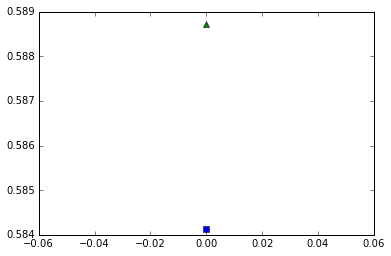

In [2]:
%time

# initializing 
graphs_pos= gspan_to_eden('bursi.pos.gspan')
graphs_neg= gspan_to_eden('bursi.neg.gspan')
originals=[]
improved=[]
percentages=[.2,.4,.6,.8,1]
percentages=[.1]

for perc in percentages:

    ######### first we generate all the iterators ###########
    # how many graphs will be used for sampling?
    count_pos = int(NUMPOS*.7*perc)
    count_neg = int(NUMNEG*.7*perc)

    # copy the mega set
    graphs_pos, graphs_pos_, graphs_pos__ = itertools.tee(graphs_pos,3)
    graphs_neg, graphs_neg_ , graphs_neg__= itertools.tee(graphs_neg,3)

    #create a shuffeld list of graph ids
    pos_id = range(NUMPOS)
    neg_id = range(NUMNEG)
    random.shuffle(pos_id)
    random.shuffle(neg_id)

    # use shuffled list to create test and sample set
    pos,pos_ = itertools.tee(  picker(graphs_pos_,pos_id[:count_pos]) )
    neg,neg_ = itertools.tee( picker (graphs_neg_,neg_id[:count_neg]))
    postest = picker(graphs_pos__,pos_id[count_pos:int(NUMPOS*.3)])
    negtest = picker(graphs_neg__,neg_id[count_neg:int(NUMNEG*.3)])


    
    ############### then we sample #####################
    improved_neg= sample(neg)
    improved_pos= sample(pos)
    
    
    ######### and last we evaluate ###########
    print 'evaluating..'
    imp,ori=train_estimator_and_evaluate_testsets( pos_,neg_,improved_pos, improved_neg, postest,negtest)
    improved.append(imp)
    originals.append(ori)
    print "done:"+str(perc)
    print "*"*80

print improved
print originals
# draw 
t = range(len(percentages))
plt.plot(t,originals ,'bs')
plt.plot(t, improved ,'g^')
plt.savefig('zomg2.png')
